In [1]:
import numpy as np
from IPython.display import display, Markdown, Latex, SVG, Image
import matplotlib.pyplot as plt
from datetime import datetime
from pykat import finesse as finesse         
from pykat.commands import *               
pykat.init_pykat_plotting(mode='display', fmts=['svg'])

                                              ..-
    PyKat 1.2.73          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



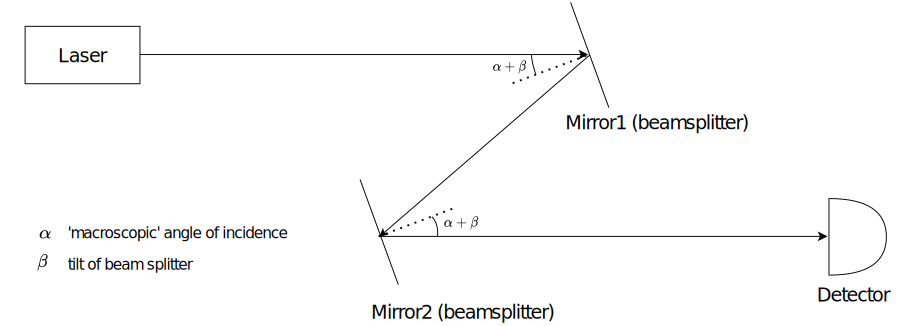

In [2]:
display(SVG("Telescope1.svg"))

## several simulations investigating:
1. convergence as function of maxtem
2. find valid parameter ranges:
    - tilt angle $\beta$
    - distance between beamsplitters $s_2$

### Setup
- laser: 1.5W, node n0
- gaussian beam: waist w0 = 10mm, default pos z0 = 1.2km right of laser
- default maxtem 7
- space s1 till 1st bs1: 1km
- beamsplitter bs1: R=1, T=0, $\varphi=0$. Angle e.g. $\alpha=30°$
- space s2 between bs1 node2 and bs2 node1: default 400 meter
- beamsplitter bs2: angle same as bs1 (in this case $\alpha=30°$)
- space s3 between bs2 node 2 and photodiode: default 600 meter
- photodiode pd1 at node n1 to measure total beam energy


In [3]:
# Define base simulation katfile: some parameters will change dependending on simulation
z0_default = -1200
maxtem_default = 7
s2_default = 400
s3_default = 600

basecode = """
const alpha 30                          # angle of incidence for both BS in degrees

# experimental setup:
l laser 1.5 0 n0                        # laser (Power = 1.5 W, wavelength offset = 0)

gauss g_n0 laser n0 10e-3 {}            # default gaussian: 10mm waist, 1.2km right of laser

maxtem {}                               # default maxtem: 7

s s1 1000 n0 nb11                       # space of 1km till first beam splitter
bs bs1 1 0 0 $alpha nb11 nb12 nb13 nb14 # beam splitter 1 (R = 1.0, T = 0.0, phi = 0°, alpha = 30°)
s s2 {} nb12 nb21                       # default space between 2 beam splitters: 400 meter
bs bs2 1 0 0 $alpha nb21 nb22 nb23 nb24 # beam splitter 2 (R = 1.0, T = 0.0, phi = 0°, alpha = 30°)

s s3 {} nb22 n1                         # default distance between bs2 and photodiode: 600 meter
pd pd1 n1                               # use photodiode to measure integrated power

yaxis abs
""".format(z0_default, maxtem_default, s2_default, s3_default)

basekat=finesse.kat(tempdir="/tmp/", tempname="kattest") # initialising Finesse
basekat.verbose = False
basekat.parse(basecode)
#print(basekat)

### First set of simulations: effect of maxtem on total energy as function of tilt $\beta$
vary $\beta$ between 0 and $4 \cdot 10^{-5}$: expect to see power "missing" for larger $\beta$ when the paraxial approximation starts to fail

#### First subsimulation: measure at different maxtem
maxtem 3, 5, 7, 9

In [4]:
# First subsimulation: effect of maxtem on power versus xbeta (fixed distance)
code = """
maxtem {}

xaxis bs1 xbeta lin 0 4e-5 40           # x-axis: vary xbeta of bs1 between 0 and 4·10^-5
put bs2 xbeta $x1                       # use same xbeta for bs2
"""

maxtemarr = [3,5,7,9]
maxtemcol = ['r', 'b', 'g', 'm']
out1a = []
for sim in range(len(maxtemarr)):
    print("Running simulation for maxtem {}".format(maxtemarr[sim]))
    kat1a = deepcopy(basekat)
    kat1a.parse(code.format(maxtemarr[sim]))
    out1a.append(kat1a.run())

Running simulation for maxtem 3
Running simulation for maxtem 5
Running simulation for maxtem 7
Running simulation for maxtem 9


#### Second subsimulation: verify this convergence is independent of the position of the photodiode
photodiode at positions 600 and 1000 meter

In [5]:
# Second subsimulation: effect of distance along beam on power versus xbeta (fixed maxtem)
code = """
s s3 {} nb22 n1

xaxis bs1 xbeta lin 0 4e-5 40           # x-axis: vary xbeta of bs1 between 0 and 4·10^-5
put bs2 xbeta $x1                       # use same xbeta for bs2
"""

s3arr = [600, 1000]
s3col = ['g', 'b.']
out1b = []
for sim in range(len(s3arr)):
    print("Running simulation for distance {}".format(s3arr[sim]))
    kat1b = deepcopy(basekat)
    kat1b.parse(code.format(s3arr[sim]))
    out1b.append(kat1b.run())

Running simulation for distance 600
Running simulation for distance 1000


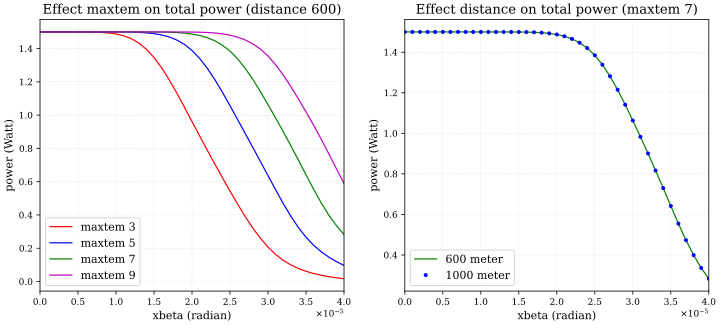

In [6]:
# Plot both subsimulations
f,ax = plt.subplots(ncols=2, figsize=(12, 5))

for sim in range(len(out1a)):
    ax[0].plot(out1a[sim].x, out1a[sim]['pd1'],
               maxtemcol[sim], label="maxtem {}".format(maxtemarr[sim]))
ax[0].set_title("Effect maxtem on total power (distance {})".format(s3_default))
ax[0].set_xlabel("xbeta (radian)")
ax[0].set_ylabel("power (Watt)")
ax[0].legend()

for sim in range(len(out1b)):
    ax[1].plot(out1b[sim].x, out1b[sim]['pd1'],
               s3col[sim], label="{} meter".format(s3arr[sim]))
ax[1].set_title("Effect distance on total power (maxtem {})".format(maxtem_default))
ax[1].set_xlabel("xbeta (radian)")
ax[1].set_ylabel("power (Watt)")
ax[1].legend(loc="lower left")

plt.savefig("totalpower_converge_maxtem_distance.svg")
plt.show()

### Second set of simulations: Convergence as function of $\beta$ and waist position $z_0$
- vary $\beta$ between $1 \cdot 10^{-5}$ and $4 \cdot 10^{-5}$ radians
- two subsimulations, using a different range for $z_0$:
    1. $z_0$ ranging from laser till photodiode,
       i.e. w.r.t. laser $z_0 = - [0 \dots 2000]$
    1. $z_0$ ranging from 400 meter left of bs1 till 200 meter right of bs2,
       i.e. w.r.t. laser $z_0 = - [600 \dots 1600]$

In [7]:
# Vary position gaussian waist: full range from laser (0) till photodetector (2000)
code = """
xaxis bs1 xbeta lin 1e-5 4e-5 40  # x-axis: vary xbeta of bs1 between 1e-5 and 4·10^-5
put bs2 xbeta $x1                 # use same xbeta for bs2

x2axis g_n0 zx lin 0 -2000 60     # pos. is distance left of laser, from 0 to 2000 right
put g_n0 zy $x2                   # same z0 for x and y
"""

kat2a = deepcopy(basekat)
kat2a.parse(code)
#print(kat2a)

In [8]:
# Zoom in: vary position from 400 left of BS1 to 200 right of BS2
code = """
xaxis bs1 xbeta lin 1e-5 4e-5 40  # x-axis: vary xbeta of bs1 between 1e-5 and 4·10^-5
put bs2 xbeta $x1                 # use same xbeta for bs2

x2axis g_n0 zx lin -600 -1600 60  # pos. dist means dist left of laser
put g_n0 zy $x2                   # same z0 for x and y
"""

kat2b = deepcopy(basekat)
kat2b.parse(code)
#print(kat2b)

In [9]:
# Run first subsimulation
t1 = datetime.now().strftime("%s.%f")
out2a = kat2a.run()
t2 = datetime.now().strftime("%s.%f")
print("runtime: {:.2f} sec.".format(float(t2)-float(t1)))

runtime: 42.03 sec.


In [10]:
# Run second subsimulation
t1 = datetime.now().strftime("%s.%f")
out2b = kat2b.run()
t2 = datetime.now().strftime("%s.%f")
print("runtime: {:.2f} sec.".format(float(t2)-float(t1)))

runtime: 43.35 sec.


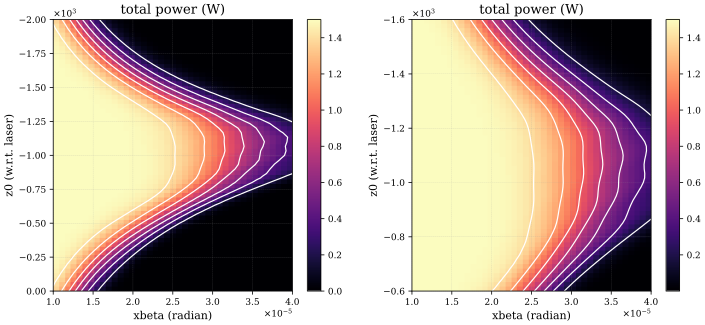

In [11]:
# Plot both simulations
f,ax = plt.subplots(ncols=2, figsize=(11.8, 5))

# Full range
pxy_extent = (out2a.x.min(), out2a.x.max(), out2a.y.max(), out2a.y.min())
p = ax[0].imshow(out2a['pd1'], aspect='auto', extent = pxy_extent)
plt.colorbar(p, ax = ax[0])
ax[0].contour(out2a['pd1'], colors='white', extent = pxy_extent)
ax[0].set_xlabel("xbeta (radian)")
ax[0].set_ylabel("z0 (w.r.t. laser)")
ax[0].set_title("total power (W)")
ax[0].ticklabel_format(style='sci', scilimits=(0,0)) # Use scientific notification for all

# Zoomed-in
pxy_extent = (out2b.x.min(), out2b.x.max(), out2b.y.max(), out2b.y.min())
p = ax[1].imshow(out2b['pd1'], aspect='auto', extent = pxy_extent)
plt.colorbar(p, ax = ax[1])
ax[1].contour(out2b['pd1'], colors='white', extent = pxy_extent)
ax[1].set_xlabel("xbeta (radian)")
ax[1].set_ylabel("z0 (w.r.t. laser)")
ax[1].set_title("total power (W)")
ax[1].ticklabel_format(style='sci', scilimits=(0,0)) # Use scientific notification for all

# Plot both
plt.savefig("convergance_beta_z0.svg")
plt.show()

### Third set of simulations: Convergence as function of $\beta$ and distance $s_2$
- fix gaussian waist at optimal position bs1, i.e. w.r.t. laser $z_0 = -1000$
- two subsimulations:
    1. waistsize $w_0 = 10mm$
        - vary $\beta$ between $1 \cdot 10^{-5}$ and $4 \cdot 10^{-5}$ radians
        - vary distance $s_2$ between $0$ and $1000$ meter
    1. waistsize $w_0 = 12mm$
        - vary $\beta$ between $1 \cdot 10^{-5}/1.2$ and $4 \cdot 10^{-5}/1.2$ radians
        - vary distance $s_2$ between $0$ and $1000*1.2^2$ meter

In [12]:
w0a = 10
b1 = 1e-5
b2 = 4e-5
L = 1000

# Position gauss at optimal from simulation above: at bs1
code = """
gauss g_n0 laser n0 {}e-3 -1000   # position 1000 right of laser, i.e. @bs1

xaxis bs1 xbeta lin {} {} 60  # x-axis: vary xbeta of bs1 between 1e-5 and 4·10^-5
put bs2 xbeta $x1                 # use same xbeta for bs2

x2axis s2 L lin 0 {} 60         # vary s2 from 0 to 1km
""".format(w0a,b1,b2,L)

kat3a = deepcopy(basekat)
kat3a.parse(code)
#print(kat3a)

In [13]:
w0b = 12
b1 = 1e-5/1.2
b2 = 4e-5/1.2
L = 1000*1.2**2

# Position gauss at optimal from simulation above: at bs1, now with waist 12mm
code = """
gauss g_n0 laser n0 {}e-3 -1000   # position 1000 right of laser, i.e. @bs1

xaxis bs1 xbeta lin {} {} 60  # x-axis: vary xbeta of bs1 between 1e-5 and 4·10^-5
put bs2 xbeta $x1                 # use same xbeta for bs2

x2axis s2 L lin 0 {} 60         # vary s2 from 0 to 1km
""".format(w0b,b1,b2,L)

kat3b = deepcopy(basekat)
kat3b.parse(code)
#print(kat3b)

In [14]:
# Run simulation
t1 = datetime.now().strftime("%s.%f")
out3a = kat3a.run()
t2 = datetime.now().strftime("%s.%f")
print("runtime: {:.2f} seconds".format(float(t2)-float(t1)))

runtime: 57.32 seconds


In [15]:
# Run simulation
t1 = datetime.now().strftime("%s.%f")
out3b = kat3b.run()
t2 = datetime.now().strftime("%s.%f")
print("runtime: {:.2f} seconds".format(float(t2)-float(t1)))

runtime: 60.21 seconds


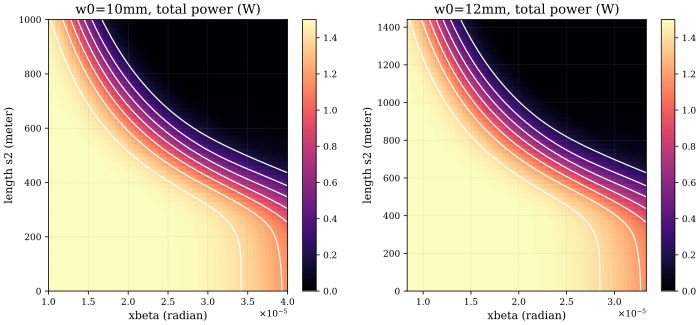

In [16]:
# Plot subplots
f,ax = plt.subplots(ncols=2, figsize=(11.8, 5))

# Setup plot
pxy_extent = ( out3a.x.min(), out3a.x.max(), out3a.y.min(), out3a.y.max())
p = ax[0].imshow(out3a['pd1'], aspect='auto', extent = pxy_extent)
plt.colorbar(p, ax = ax[0])
ax[0].contour(out3a['pd1'], colors='white', extent = pxy_extent)
ax[0].set_xlabel("xbeta (radian)")
ax[0].set_ylabel("length s2 (meter)")
ax[0].set_title("w0={}mm, total power (W)".format(w0a))
ax[0].ticklabel_format(axis='y', style='plain', scilimits=(0,0)) # Use scientific notification for all

pxy_extent = ( out3b.x.min(), out3b.x.max(), out3b.y.min(), out3b.y.max())
p = ax[1].imshow(out3b['pd1'], aspect='auto', extent = pxy_extent)
plt.colorbar(p, ax = ax[1])
ax[1].contour(out3b['pd1'], colors='white', extent = pxy_extent)
ax[1].set_xlabel("xbeta (radian)")
ax[1].set_ylabel("length s2 (meter)")
ax[1].set_title("w0={}mm, total power (W)".format(w0b))
ax[1].ticklabel_format(axis='y', style='plain', scilimits=(0,0)) # Use scientific notification for all

# Plot both
plt.savefig("convergance_beta_s2.svg")
plt.show()